## Setting up by importing modules/packages

In [21]:
%matplotlib notebook

import os
from os.path import join, basename, dirname, exists, splitext
proj_name = 'MINDLAB2016_MR-PD-MCI'
misc_folder = join('/projects', proj_name, 'misc')

import sys
sys.path = [join(misc_folder, 'mne-python'),
            join(misc_folder, 'stormdb-python')] + sys.path
#import subprocess
import socket
import numpy as np
import re 
from stormdb.access import Query
#from mne.io import Raw  
import mne
import glob
from stormdb.cluster import ClusterBatch
#import mlt_utilfuncs as mu
import matplotlib.pyplot as plt

### Defining variables (and paths)
Setting up paths

In [22]:
# Deprecated code-snippets
#hostname = socket.gethostname()
#cmd = "/usr/local/common/meeg-cfin/stormdb-python/bin/submit_to_cluster"

# defining project's folders
proj_name = 'MINDLAB2016_MR-PD-MCI'
proj_folder = join('/projects', proj_name,)
scratch_folder = join('/projects', proj_name, 'scratch/PD_MCI',)
scripts_folder = join('/projects', proj_name, 'scripts',)
misc_folder = join('/projects', proj_name, 'misc')
trans_folder = join(scratch_folder, 'trans')
mf_folder = join(scratch_folder, 'maxfilter/tsss_st16_corr96')
ica_folder = join(scratch_folder,'ICA_eog_ecg')
filtered_folder = join(scratch_folder, 'filtered',)
script_path = scripts_folder

print("Project name: {}".format(proj_name))

Project name: MINDLAB2016_MR-PD-MCI


#### Setting up variables to be used in the later processing (see below for more details)

In [23]:
# dictionary of condition names: keys = raw file name; val = ica file name
conds = {
    "open_close":"open",
    "resting":"rest",
    "eds_1":"eds",
    "eds_2":"eds2",
    "ssrt_1":"ssrt",
    "ssrt_2":"ssrt2",
    "ssrt_3":"ssrt3",
    "ssrt_4":"ssrt4",
    "ssrt_5":"ssrt5"
        }

modality = "MEG"

#### Getting an overview of available subjects and files

In [24]:
# querying all subjects in database
qr = Query(proj_name)
subs = qr.get_subjects(has_modality=modality)           

for i, s in enumerate(subs): 
    print("{0:2d}: {1:s}".format(i+1, s))


 1: 0002_ICD
 2: 0003_OPR
 3: 0004_N1F
 4: 0006_D8D
 5: 0007_URN
 6: 0008_NZE
 7: 0009_OVS
 8: 0010_RI1
 9: 0011_4N7
10: 0012_42W
11: 0013_A7G
12: 0014_NCU
13: 0015_DRK
14: 0016_TMA
15: 0017_AOD
16: 0018_1CT
17: 0019_VPK
18: 0020_B0E
19: 0021_7RL
20: 0022_YY7
21: 0023_K3U
22: 0024_J9S
23: 0026_SAK
24: 0027_F2O
25: 0028_WRH
26: 0029_FD7
27: 0030_WEY
28: 0031_U88
29: 0032_VII
30: 0033_MDL
31: 0034_UWB
32: 0035_ITN
33: 0036_YUX
34: 0037_PJV
35: 0038_5NZ
36: 0039_7KX
37: 0040_YKG
38: 0041_TMD
39: 0042_7Z7
40: 0043_ST5
41: 0044_FFM
42: 0045_JYC
43: 0046_VOR
44: 0047_RTU
45: 0048_HVH
46: 0049_C6O
47: 0050_249
48: 0051_RY5
49: 0052_GNM
50: 0053_SKY
51: 0054_GME
52: 0055_RKH
53: 0056_DCK
54: 0058_RBF
55: 0059_FNO
56: 0060_ZCX


#### Get an "example" list of series for an "example" subject (aka. the first subject)

In [25]:
study_id = qr.get_studies(subs[0], modality=modality)
example_blocks = qr.get_series(subs[0], study=study_id[0], modality=modality)

print("Subject: {0:s}".format(subs[0]))
print("Study ID: {0:s} \n".format(study_id[0]))
for i, b in enumerate(example_blocks): 
    print("{0:2d}: {1:s}".format(i+1, b))

Subject: 0002_ICD
Study ID: 20181210_000000 

 1: open_close
 2: resting
 3: eds_1
 4: eds_2
 5: ssrt_1
 6: ssrt_2
 7: ssrt_3
 8: ssrt_4
 9: ssrt_5
10: s_semantic_1
11: s_semantic_2
12: s_syntax_1
13: s_syntax_2
14: laes_semantic_1
15: laes_semantic_2


## Use this to manually specify which subject we're working on:
Specify the number (aka. index) of the relevant subject in the overview in the above (i.e. the subs-list is actually zero-indexed, but the overview in the above starts at 1, hence the subj_index in the below is adjusted by 1 when calling the subs-list)

In [48]:
subj_index = 3
cur_sub = subs[subj_index-1]
study_id = qr.get_studies(cur_sub, modality)[0]

blocks = qr.get_series(cur_sub, study_id, modality)

print("Subject: {0:s}".format(cur_sub))
print("Study ID: {0:s} \n".format(study_id))

# Create a list of tuples sorted by index 1 i.e. value field   
int_blocks = {k : int(v) for k, v in blocks.items()}
series_sorted = sorted(int_blocks.items() ,  key=lambda x: x[1])
 
# Iterate over the sorted sequence
for elem in series_sorted:
    print("{0:2d}: {1:s}".format(elem[1], elem[0]))
    

Subject: 0004_N1F
Study ID: 20181121_000000 

 1: open_close
 2: resting
 3: eds_1
 4: eds_2
 5: ssrt_1
 6: ssrt_2
 7: ssrt_3
 8: ssrt_4
 9: ssrt_5
10: s_semantic_1
11: s_semantic_2
12: laes_semantic_2
13: laes_semantic_1
14: s_syntax_2
15: s_syntax_1
16: equi_bi_1
17: equi_bi_2


### Specify which series (i.e. which series "key")
Specify the "name" (aka. "key") of the relevant series (or block) in the overview immediately above here (NB! the series are a dictionary).

In [76]:
raw_series_key = 'eds_2'
raw_series_val = int_blocks[raw_series_key]
file_list = qr.get_files(cur_sub, study_id, modality, raw_series_val)

print("Current series raw name: {0:s} \nCurrent series raw number: {1:2d}".format(raw_series_key, raw_series_val))
for f in file_list:
    print("\nNumber of raw files: {0:d} \nRaw file name: {1:s}".format(len(file_list), f))

Current series raw name: eds_2 
Current series raw number:  4

Number of raw files: 1 
Raw file name: /projects/MINDLAB2016_MR-PD-MCI/raw/0004/20181121_000000/MEG/004.eds_2/files/eds_2.fif


In [77]:
raw_file_id = splitext(basename(file_list[0]))[0]
ica_file_id = conds[raw_file_id]

## set path and subs
raw_root     = mf_folder  # filtered_folder
ica_root     = ica_folder
art_rej_root = join(ica_folder, cur_sub)
results_root = join(art_rej_root, ica_file_id + '_manual')
cur_file     = join(art_rej_root, ica_file_id + '_ica.fif')
cur_raw_file = join(mf_folder, cur_sub, ica_file_id + "_raw_tsss.fif")

if not exists(results_root):
    print('Created directory: {0:s}'.format(results_root))
    os.makedirs(results_root)
    
print("\nCurrent file: {0:s}".format(cur_file))
print("Current \"raw\" file: {0:s}".format(cur_raw_file))


Current file: /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/ICA_eog_ecg/0004_N1F/eds2_ica.fif
Current "raw" file: /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/maxfilter/tsss_st16_corr96/0004_N1F/eds2_raw_tsss.fif


Reading /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/ICA_eog_ecg/0004_N1F/eds2_ica.fif ...
Now restoring ICA solution ...
Ready.
Pre-selected components: 3, 0, 15
Old components copied to .exclude_old. 
.exclude-field cleared
Opening raw data file /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/maxfilter/tsss_st16_corr96/0004_N1F/eds2_raw_tsss.fif...
    Range : 22000 ... 398999 =     22.000 ...   398.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 376999  =      0.000 ...   376.999 secs...


<IPython.core.display.Javascript object>


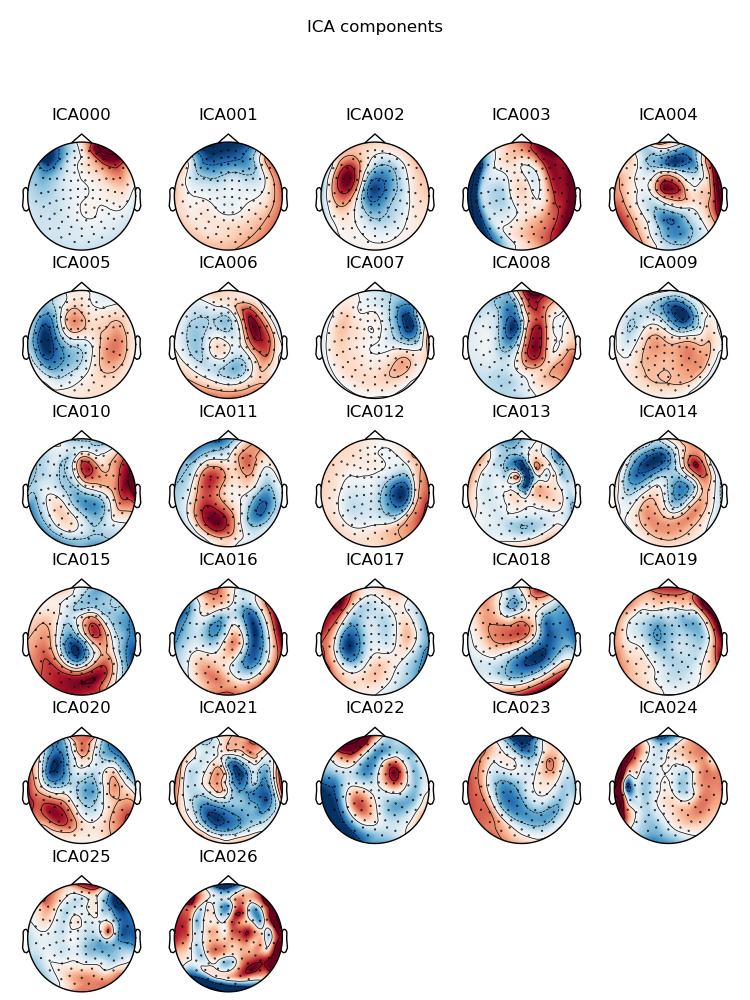

In [78]:
icacomps = mne.preprocessing.read_ica(cur_file)
if icacomps.exclude:
    print("Pre-selected components: {0:s}".format(', '.join(map(str, icacomps.exclude))))
    icacomps.exclude_old = icacomps.exclude
    icacomps.exclude = []
if not icacomps.exclude:
    print('Old components copied to .exclude_old. \n.exclude-field cleared')    

raw = mne.io.Raw(cur_raw_file, preload=True)

ecg_picks = mne.pick_types(raw.info, meg=False, eeg=False, eog=False, ecg=True,
               stim=False, exclude='bads')[0]
eog_picks = mne.pick_types(raw.info, meg=False, eeg=False, ecg=False, eog=True,
               stim=False, exclude='bads')[0]  ##changed back from 1 
meg_picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=False, ecg=False,
                   stim=False, exclude='bads')               

ecg_evoked = mne.preprocessing.create_ecg_epochs(raw, tmin=-.5, tmax=.5,picks=meg_picks, verbose=False).average()
                               #ch_name=raw.ch_names[ecg_picks].encode('UTF8'))
eog_evoked = mne.preprocessing.create_eog_epochs(raw, tmin=-.5, tmax=.5,picks=meg_picks, verbose=False).average()
                               #ch_name=raw.ch_names[eog_picks].encode('UTF8'), verbose=False).average()

# option to use one of the MEG-channels as pseudo-EOG-channel if the EOG-channel is too noisy
#eog_evoked = mne.preprocessing.create_eog_epochs(raw, tmin=-.5, tmax=.5,picks=meg_picks,
#                       ch_name="MEG0511", verbose=False).average()

# ica topos
source_idx = range(0, icacomps.n_components_)
ica_plot = icacomps.plot_components(source_idx, ch_type="mag")

## ECG artefacts

<IPython.core.display.Javascript object>


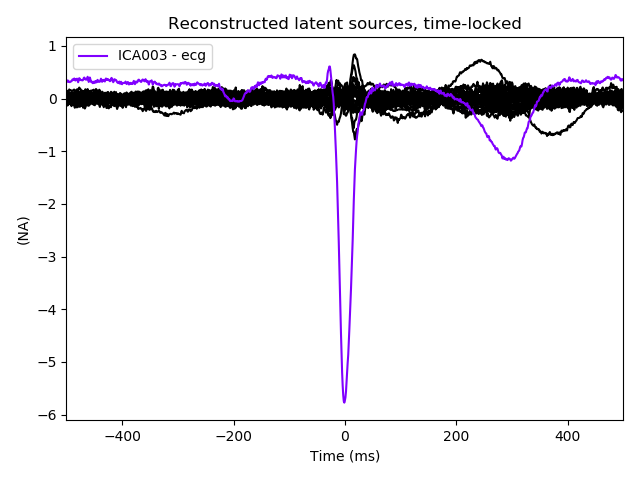

Transforming to ICA space (27 components)
Zeroing out 1 ICA components


<IPython.core.display.Javascript object>


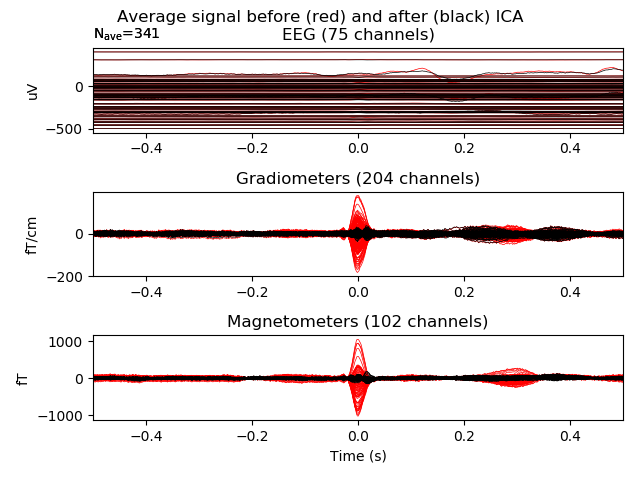

In [79]:
# [ECG] What components should be rejected as ECG comps? (Input them as a list; if none, leave empty)
ecg_exclude = [3]

source_plot_ecg = icacomps.plot_sources(ecg_evoked, exclude=ecg_exclude)
clean_plot_ecg = icacomps.plot_overlay(ecg_evoked, exclude=ecg_exclude)

## Clean enough? [ECG]
Otherwise repeat previous step (aka. "What components should ...") with a different selection of components 

Once you're happy with your selection of components, proceed to the next step (aka. "Rejecting new selection ...")

In [80]:
# [ECG] Rejecting new selection of components (if any selected)

icacomps.labels_.update({'ecg': ecg_exclude, 'ecg/ECG-MAG': ecg_exclude})    

if ecg_exclude:
    icacomps.ecg_source = ecg_exclude
    source_plot_ecg.savefig(join(results_root, ica_file_id + '_ecg_source_vis.pdf'), format = 'pdf')
    clean_plot_ecg.savefig(join(results_root, ica_file_id + '_ecg_clean_vis.pdf'), format = 'pdf')
    print("ECG exclusion components changed to: [{0:s}]".
          format(', '.join(map(str, icacomps.ecg_source))))
else:
    print('*** No ECG components rejected ...')

ECG exclusion components changed to: [3]


## EOG artefacts

<IPython.core.display.Javascript object>


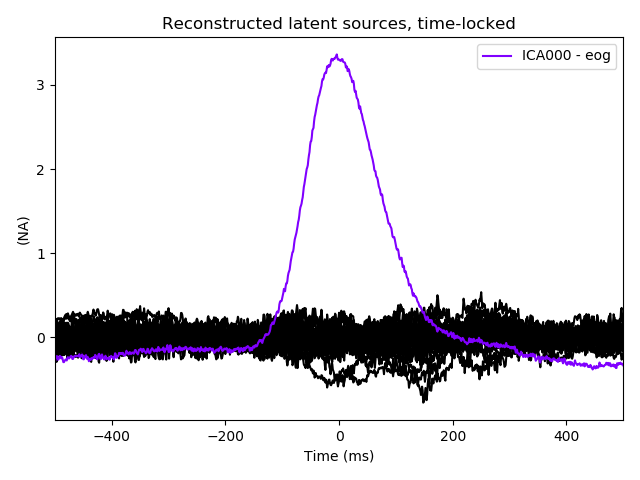

Transforming to ICA space (27 components)
Zeroing out 1 ICA components


<IPython.core.display.Javascript object>


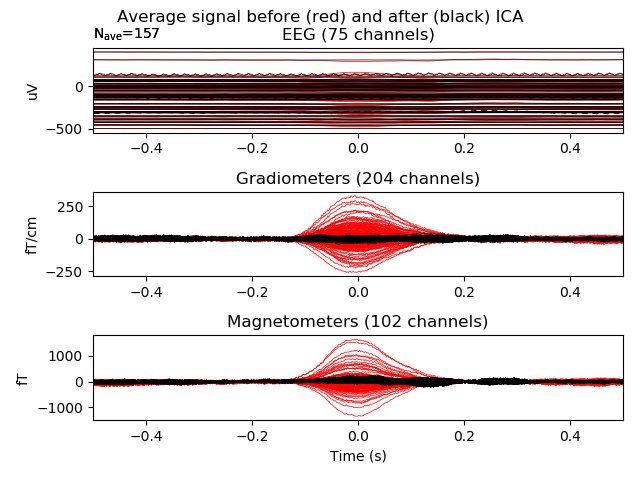

In [81]:
# [EOG] What components should be rejected as EOG comps? (Input them as a list; if none, leave empty)
eog_exclude = [0]

source_plot_eog = icacomps.plot_sources(eog_evoked, exclude=eog_exclude)
clean_plot_eog = icacomps.plot_overlay(eog_evoked, exclude=eog_exclude)

## Clean enough? [EOG]
Otherwise repeat previous step (aka. "[EOG] What components should ...") with a different selection of components 

Once you're happy with your selection of components, proceed to the next step (aka. " [EOG] Rejecting new selection ...")

In [82]:
# [EOG] Rejecting new selection of components (if any selected)

icacomps.labels_.update({'eog': eog_exclude, 'eog/EOG-MAG': eog_exclude}) 

if eog_exclude:
    icacomps.eog_source = eog_exclude
    source_plot_eog.savefig(join(results_root, ica_file_id + '_eog_source_vis.pdf'), format = 'pdf')
    clean_plot_eog.savefig(join(results_root, ica_file_id + '_eog_clean_vis.pdf'), format = 'pdf')
    print("*** EOG exclusion components changed to: [{0:s}]".
          format(', '.join(map(str, icacomps.eog_source))))
else:
    print ("*** No EOG components rejected...")
    

*** EOG exclusion components changed to: [0]


## Excluding manually selected components and saving anew

In [83]:
icacomps.exclude = ecg_exclude + eog_exclude

if icacomps.exclude_old == icacomps.exclude:
    print("Old list of comps for exclusion is identical to the new one, hence nothing's done")    
else:
    print("*** Excluding the following components: {0:s}".format(', '.join(map(str, icacomps.exclude))))

    ica_plot.savefig(join(results_root, ica_file_id + 
                          ('_comps_eog{0:s}-ecg{1:s}.pdf'.
                           format('_'.join(map(str,eog_exclude)),
                                           '_'.join(map(str,ecg_exclude))))),format='pdf')

    raw_ica = icacomps.apply(raw)
    save_name = join(art_rej_root, ica_file_id + '_ica-raw.fif')
    #raw_ica.save(save_name, overwrite=False, verbose=False)
    # Option to overwrite existing files if necessary
    raw_ica.save(save_name, overwrite=True, verbose=False)
    print('Saved as {0:s}'.format(save_name))

del ecg_exclude, eog_exclude

print ("\necg_exclude and eog_exclude deleted")

*** Excluding the following components: 3, 0
Transforming to ICA space (27 components)
Zeroing out 2 ICA components
Saved as /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/ICA_eog_ecg/0004_N1F/eds2_ica-raw.fif

ecg_exclude and eog_exclude deleted
